# Imports

In [1]:
import torch
import torch.utils.data
from torch.utils.data import DataLoader
from torch import nn
import torch.nn.functional as F
from torch import optim

import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image
import torch.nn.functional as F

import tqdm
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable
from sklearn.manifold import TSNE


# Download Dataset

In [2]:
bs = 100

transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: torch.flatten(x))])
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=False)

# Data Loaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

# Autoencoder

In [ ]:
class Autoencoder(nn.Module):

  def __init__(
      self,
      input_dim: int = 784,
      hidden_dim: int = 256,
      device: str = "cuda"
  ):
    super(Autoencoder, self).__init__()
    self.device = device


    self.encoder = torch.nn.Sequential(
        torch.nn.Linear(input_dim, hidden_dim),
        torch.nn.ReLU(),
        torch.nn.Linear(hidden_dim, 128),
        torch.nn.ReLU()
    )

    self.decoder = torch.nn.Sequential(
        torch.nn.Linear(128, hidden_dim),
        torch.nn.ReLU(),
        torch.nn.Linear(hidden_dim, 512),
        torch.nn.ReLU(),
        torch.nn.Linear(512, input_dim),
        torch.nn.Sigmoid()
    )

  def forward(self, x):
    latent = self.encoder(x)
    reconstruction = self.decoder(latent)
    return reconstruction

# Variational Autoencoder

In [ ]:
class VAE(nn.Module):

  def __init__(self, input_dim: int = 784, hidden_dim: int = 256, latent_dim: int = 2, device: str = "cuda"):
    super(VAE, self).__init__()
    self.latent_dim = latent_dim
    self.device = device

    self.encoder = nn.Sequential(
        nn.Linear(input_dim, 512),
        nn.ReLU(),
        nn.Linear(512, hidden_dim), 
        nn.ReLU(),
    )

    self.decoder =  nn.Sequential(      
        nn.Linear(latent_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, 512),
        nn.ReLU(),
        nn.Linear(512, input_dim),
        nn.Sigmoid(),
    )

    self.mean = nn.Linear(hidden_dim, latent_dim)

    self.log_var =  nn.Linear(hidden_dim, latent_dim)

  def reparameterize(self, mu, log_var):
    std = torch.exp(0.5 * log_var)
    eps = torch.randn_like(std)
    return eps.mul(std).add_(mu)

  def sample(self, n):
    sample = torch.randn(n, self.latent_dim).to(self.device)
    return self.decoder(sample)

  def forward(self, x):

    latent = self.encoder(x)
    mu = self.mean(latent)
    log_var = self.log_var(latent)
    z = self.reparameterize(mu,log_var)
    reconstruction = self.decoder(z)

    return reconstruction, mu, log_var

In [5]:
# Define training variables, feel free to modify these for the problem
log_interval = 100
num_epochs = 10
image, cls = train_dataset[0]
input_dim = np.product(image.shape)
hidden_dim = 32
latent_dim = 2
batch_size = 100
num_examples = len(train_dataset)
device = "cuda" if torch.cuda.is_available() else "cpu"

def train_single_epoch(
    model_cls: str,
    model: nn.Module,
    loss_fn: Callable,
    data_loader: DataLoader,
    optimizer,
    epoch: int
):
  # set model to training mode
  model.train()
  train_loss = 0
  train_losss = 0

  for batch_idx, (data, class_label) in enumerate(data_loader):
    data = data.to(device)
    class_label = class_label.to(device)

    optimizer.zero_grad()

    if model_cls == "ae":
      recon_batch = model(data)
      # compute loss
      loss = loss_fn(recon_batch, data)
    elif model_cls == "vae":
      recon_batch, mu, log_var = model(data)
      # compute loss
      loss = loss_fn(recon_batch, data, mu, log_var)
    elif model_cls == "cvae":
      recon_batch, mu, log_var = model(data, class_label)
      # compute loss
      loss = loss_fn(recon_batch, data, mu, log_var)
    else:
      raise NotImplementedError

    loss.backward()
    train_loss += loss.item()
    train_losss += F.binary_cross_entropy(recon_batch,data,reduction='mean').item()
    optimizer.step()

    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(data_loader.dataset),
            100. * batch_idx / len(data_loader), loss.item() / len(data)))
    
  print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(data_loader.dataset)))
  
  # Plot reconstructions
  n = min(num_examples, 8)
  imgs = data[:n]
  reconstructed_imgs = recon_batch.view(batch_size,-1, 28, 28)[:n]

  imgs = imgs.view(8,-1, 28, 28)[:n]
  comparisons = torch.cat([imgs, reconstructed_imgs])

  # sample some from the latent space, with class label 0
  if model_cls in ["vae", "cvae"]:
    latent_samples = model.sample(n=n)
    latent_samples = latent_samples.view(n, -1, 28, 28)
    comparisons = torch.cat([comparisons, latent_samples])

  comparisons = torchvision.utils.make_grid(comparisons)
  comparisons = comparisons.detach().cpu().numpy()

  print("Reconstructions: ")
  plt.imshow(comparisons.transpose(1,2,0))
  plt.axis('off')
  plt.show()
  return train_losss / len(data_loader.dataset)

In [ ]:
def validate_single_epoch(
    model_cls: str,
    model: nn.Module,
    data_loader: DataLoader,
    epoch: int
    ):
    model.eval()
    batch_size = 100
    test_loss = 0
    with torch.no_grad():
        for i, (data, class_label) in enumerate(data_loader):
            data = data.to(device)
            if model_cls == "ae":
                recon_batch = model(data)
                test_loss += F.binary_cross_entropy(recon_batch, data, reduction='mean').item()
            elif model_cls == "vae":
                recon_batch, mu, log_var = model(data)
                test_loss += F.binary_cross_entropy(recon_batch, data,reduction='mean').item()
            elif model_cls == "cvae":
                recon_batch, mu, log_var = model(data, class_label)
                test_loss += F.binary_cross_entropy(recon_batch, data,reduction='mean').item()
            else:
                raise NotImplementedError
    outputs = None
    if epoch == 9:
        n = 25
        outputs = recon_batch.view(batch_size,-1, 28, 28)[:n]

        #    latent_samples = model.sample(n=n)
        #    outputs = latent_samples.view(n, -1, 28, 28)

        outputs = torchvision.utils.make_grid(outputs, nrow=5)
        outputs = outputs.detach().cpu().numpy()



    return test_loss/len(data_loader.dataset), outputs

In [7]:
def get_embeddings(model_cls: str,
    model: nn.Module,
    data_loader: DataLoader):
    model.eval()
    embeddings = []
    labels = []
    for img, class_label in data_loader:
        img = img.view(img.shape[0], -1).to(device)
        class_label = class_label.to(device)
        with torch.no_grad():
            if model_cls == "ae":
                latent = model.encoder(img)
            elif model_cls == "vae":
                latent = model.mean(model.encoder(img))
            elif model_cls == "cvae":
                latent,_ = model.encode(img, class_label)
            else:
                raise NotImplementedError
    
            embeddings.append(latent)
            labels.append(class_label)
    return torch.cat(embeddings), torch.cat(labels)

# Train Autoencoder

Hidden dim:  32
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.006932
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.002426
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.001931
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.001638
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.001531
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.001492
====> Epoch: 1 Average loss: 0.0019
Reconstructions: 


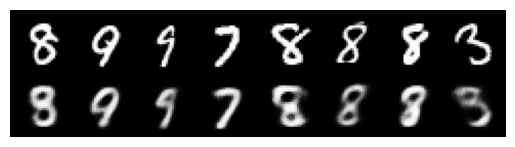

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.001369
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.001313
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.001300
Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.001187
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.001193
Train Epoch: 2 [50000/60000 (83%)]	Loss: 0.001206
====> Epoch: 2 Average loss: 0.0012
Reconstructions: 


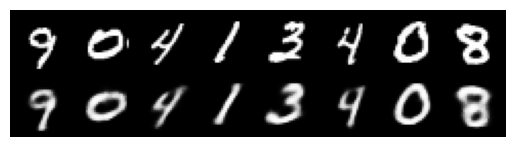

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.001220
Train Epoch: 3 [10000/60000 (17%)]	Loss: 0.001140
Train Epoch: 3 [20000/60000 (33%)]	Loss: 0.001129
Train Epoch: 3 [30000/60000 (50%)]	Loss: 0.001124
Train Epoch: 3 [40000/60000 (67%)]	Loss: 0.001102
Train Epoch: 3 [50000/60000 (83%)]	Loss: 0.001099
====> Epoch: 3 Average loss: 0.0011
Reconstructions: 


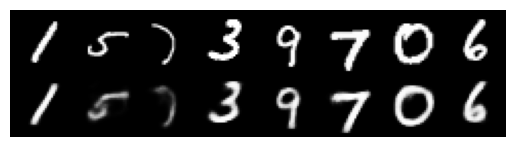

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.001058
Train Epoch: 4 [10000/60000 (17%)]	Loss: 0.001122
Train Epoch: 4 [20000/60000 (33%)]	Loss: 0.001058
Train Epoch: 4 [30000/60000 (50%)]	Loss: 0.001053
Train Epoch: 4 [40000/60000 (67%)]	Loss: 0.001036
Train Epoch: 4 [50000/60000 (83%)]	Loss: 0.000982
====> Epoch: 4 Average loss: 0.0011
Reconstructions: 


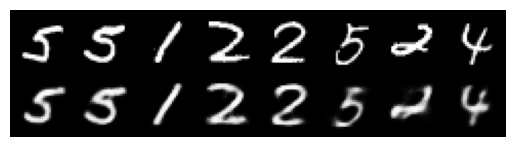

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.001044
Train Epoch: 5 [10000/60000 (17%)]	Loss: 0.001048
Train Epoch: 5 [20000/60000 (33%)]	Loss: 0.001045
Train Epoch: 5 [30000/60000 (50%)]	Loss: 0.001017
Train Epoch: 5 [40000/60000 (67%)]	Loss: 0.001012
Train Epoch: 5 [50000/60000 (83%)]	Loss: 0.001041
====> Epoch: 5 Average loss: 0.0010
Reconstructions: 


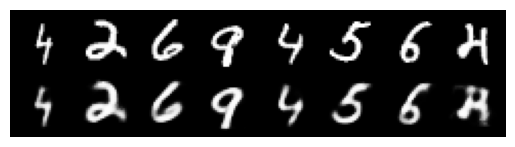

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.001023
Train Epoch: 6 [10000/60000 (17%)]	Loss: 0.001016
Train Epoch: 6 [20000/60000 (33%)]	Loss: 0.000985
Train Epoch: 6 [30000/60000 (50%)]	Loss: 0.000967
Train Epoch: 6 [40000/60000 (67%)]	Loss: 0.001043
Train Epoch: 6 [50000/60000 (83%)]	Loss: 0.000995
====> Epoch: 6 Average loss: 0.0010
Reconstructions: 


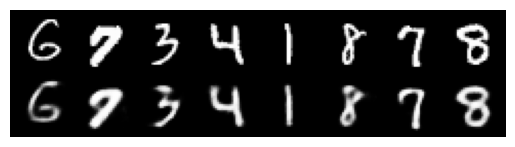

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.000974
Train Epoch: 7 [10000/60000 (17%)]	Loss: 0.000935
Train Epoch: 7 [20000/60000 (33%)]	Loss: 0.000966
Train Epoch: 7 [30000/60000 (50%)]	Loss: 0.000944
Train Epoch: 7 [40000/60000 (67%)]	Loss: 0.000946
Train Epoch: 7 [50000/60000 (83%)]	Loss: 0.000942
====> Epoch: 7 Average loss: 0.0009
Reconstructions: 


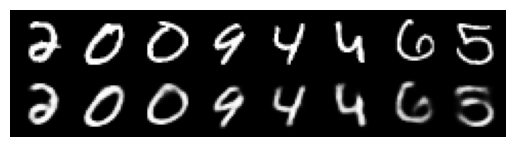

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.000943
Train Epoch: 8 [10000/60000 (17%)]	Loss: 0.000988
Train Epoch: 8 [20000/60000 (33%)]	Loss: 0.000855
Train Epoch: 8 [30000/60000 (50%)]	Loss: 0.000935
Train Epoch: 8 [40000/60000 (67%)]	Loss: 0.000894
Train Epoch: 8 [50000/60000 (83%)]	Loss: 0.000970
====> Epoch: 8 Average loss: 0.0009
Reconstructions: 


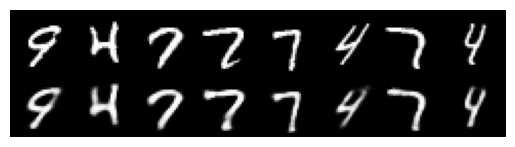

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.000921
Train Epoch: 9 [10000/60000 (17%)]	Loss: 0.000919
Train Epoch: 9 [20000/60000 (33%)]	Loss: 0.000920
Train Epoch: 9 [30000/60000 (50%)]	Loss: 0.000927
Train Epoch: 9 [40000/60000 (67%)]	Loss: 0.000905
Train Epoch: 9 [50000/60000 (83%)]	Loss: 0.000915
====> Epoch: 9 Average loss: 0.0009
Reconstructions: 


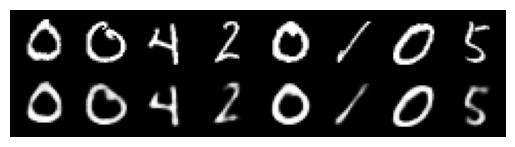

Hidden dim:  128
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.006933
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.002379
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.001852
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.001517
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.001413
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.001409
====> Epoch: 1 Average loss: 0.0019
Reconstructions: 


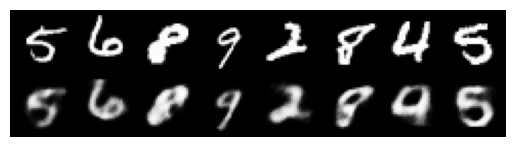

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.001232
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.001182
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.001234
Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.001103
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.001144
Train Epoch: 2 [50000/60000 (83%)]	Loss: 0.001151
====> Epoch: 2 Average loss: 0.0012
Reconstructions: 


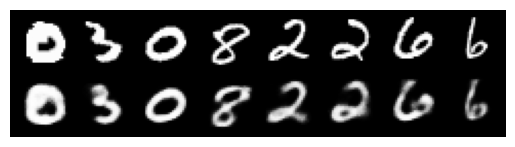

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.001067
Train Epoch: 3 [10000/60000 (17%)]	Loss: 0.001005
Train Epoch: 3 [20000/60000 (33%)]	Loss: 0.001025
Train Epoch: 3 [30000/60000 (50%)]	Loss: 0.001069
Train Epoch: 3 [40000/60000 (67%)]	Loss: 0.000986
Train Epoch: 3 [50000/60000 (83%)]	Loss: 0.000950
====> Epoch: 3 Average loss: 0.0010
Reconstructions: 


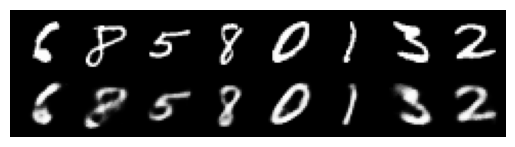

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.000958
Train Epoch: 4 [10000/60000 (17%)]	Loss: 0.000973
Train Epoch: 4 [20000/60000 (33%)]	Loss: 0.000918
Train Epoch: 4 [30000/60000 (50%)]	Loss: 0.000954
Train Epoch: 4 [40000/60000 (67%)]	Loss: 0.000903
Train Epoch: 4 [50000/60000 (83%)]	Loss: 0.000932
====> Epoch: 4 Average loss: 0.0009
Reconstructions: 


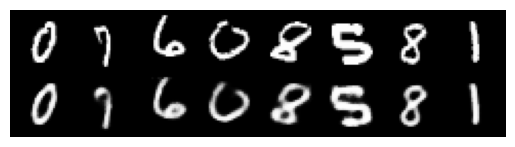

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.000867
Train Epoch: 5 [10000/60000 (17%)]	Loss: 0.000900
Train Epoch: 5 [20000/60000 (33%)]	Loss: 0.000871
Train Epoch: 5 [30000/60000 (50%)]	Loss: 0.000911
Train Epoch: 5 [40000/60000 (67%)]	Loss: 0.000881
Train Epoch: 5 [50000/60000 (83%)]	Loss: 0.000864
====> Epoch: 5 Average loss: 0.0009
Reconstructions: 


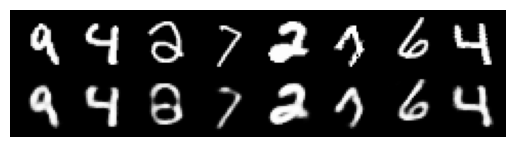

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.000890
Train Epoch: 6 [10000/60000 (17%)]	Loss: 0.000856
Train Epoch: 6 [20000/60000 (33%)]	Loss: 0.000870
Train Epoch: 6 [30000/60000 (50%)]	Loss: 0.000880
Train Epoch: 6 [40000/60000 (67%)]	Loss: 0.000850
Train Epoch: 6 [50000/60000 (83%)]	Loss: 0.000796
====> Epoch: 6 Average loss: 0.0009
Reconstructions: 


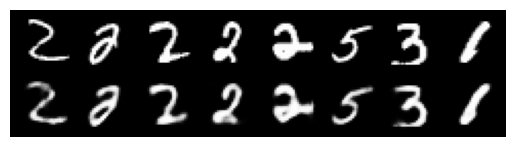

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.000826
Train Epoch: 7 [10000/60000 (17%)]	Loss: 0.000871
Train Epoch: 7 [20000/60000 (33%)]	Loss: 0.000884
Train Epoch: 7 [30000/60000 (50%)]	Loss: 0.000892
Train Epoch: 7 [40000/60000 (67%)]	Loss: 0.000844
Train Epoch: 7 [50000/60000 (83%)]	Loss: 0.000848
====> Epoch: 7 Average loss: 0.0008
Reconstructions: 


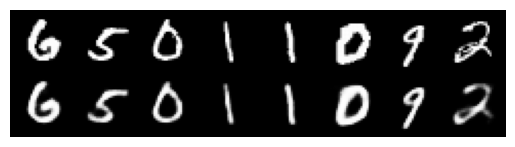

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.000840
Train Epoch: 8 [10000/60000 (17%)]	Loss: 0.000834
Train Epoch: 8 [20000/60000 (33%)]	Loss: 0.000855
Train Epoch: 8 [30000/60000 (50%)]	Loss: 0.000820
Train Epoch: 8 [40000/60000 (67%)]	Loss: 0.000807
Train Epoch: 8 [50000/60000 (83%)]	Loss: 0.000809
====> Epoch: 8 Average loss: 0.0008
Reconstructions: 


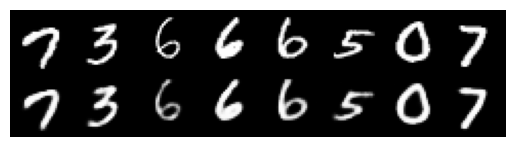

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.000857
Train Epoch: 9 [10000/60000 (17%)]	Loss: 0.000858
Train Epoch: 9 [20000/60000 (33%)]	Loss: 0.000823
Train Epoch: 9 [30000/60000 (50%)]	Loss: 0.000798
Train Epoch: 9 [40000/60000 (67%)]	Loss: 0.000847
Train Epoch: 9 [50000/60000 (83%)]	Loss: 0.000853
====> Epoch: 9 Average loss: 0.0008
Reconstructions: 


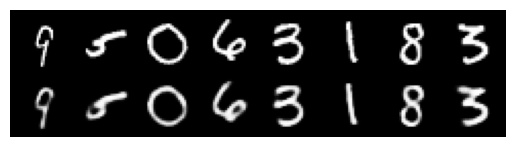

Hidden dim:  512
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.006922
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.002289
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.001780
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.001513
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.001275
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.001239
====> Epoch: 1 Average loss: 0.0017
Reconstructions: 


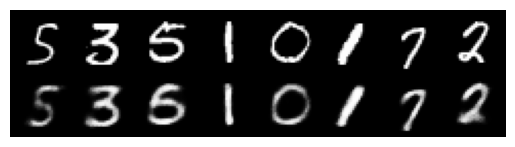

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.001235
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.001074
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.001069
Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.001019
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.000952
Train Epoch: 2 [50000/60000 (83%)]	Loss: 0.000942
====> Epoch: 2 Average loss: 0.0010
Reconstructions: 


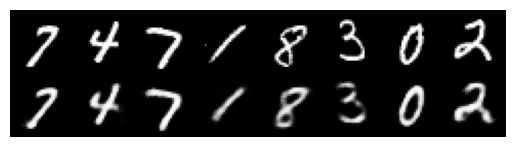

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.000950
Train Epoch: 3 [10000/60000 (17%)]	Loss: 0.000938
Train Epoch: 3 [20000/60000 (33%)]	Loss: 0.000969
Train Epoch: 3 [30000/60000 (50%)]	Loss: 0.000909
Train Epoch: 3 [40000/60000 (67%)]	Loss: 0.000860
Train Epoch: 3 [50000/60000 (83%)]	Loss: 0.000924
====> Epoch: 3 Average loss: 0.0009
Reconstructions: 


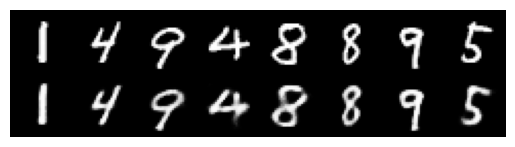

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.000899
Train Epoch: 4 [10000/60000 (17%)]	Loss: 0.000890
Train Epoch: 4 [20000/60000 (33%)]	Loss: 0.000876
Train Epoch: 4 [30000/60000 (50%)]	Loss: 0.000846
Train Epoch: 4 [40000/60000 (67%)]	Loss: 0.000830
Train Epoch: 4 [50000/60000 (83%)]	Loss: 0.000860
====> Epoch: 4 Average loss: 0.0009
Reconstructions: 


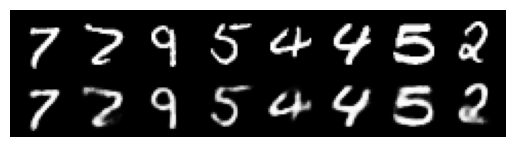

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.000862
Train Epoch: 5 [10000/60000 (17%)]	Loss: 0.000828
Train Epoch: 5 [20000/60000 (33%)]	Loss: 0.000807
Train Epoch: 5 [30000/60000 (50%)]	Loss: 0.000829
Train Epoch: 5 [40000/60000 (67%)]	Loss: 0.000822
Train Epoch: 5 [50000/60000 (83%)]	Loss: 0.000780
====> Epoch: 5 Average loss: 0.0008
Reconstructions: 


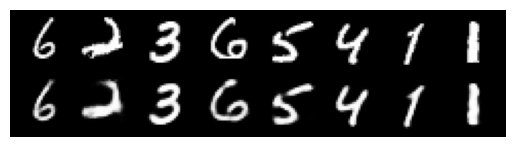

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.000774
Train Epoch: 6 [10000/60000 (17%)]	Loss: 0.000754
Train Epoch: 6 [20000/60000 (33%)]	Loss: 0.000847
Train Epoch: 6 [30000/60000 (50%)]	Loss: 0.000839
Train Epoch: 6 [40000/60000 (67%)]	Loss: 0.000775
Train Epoch: 6 [50000/60000 (83%)]	Loss: 0.000785
====> Epoch: 6 Average loss: 0.0008
Reconstructions: 


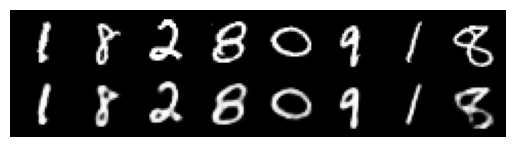

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.000748
Train Epoch: 7 [10000/60000 (17%)]	Loss: 0.000741
Train Epoch: 7 [20000/60000 (33%)]	Loss: 0.000775
Train Epoch: 7 [30000/60000 (50%)]	Loss: 0.000752
Train Epoch: 7 [40000/60000 (67%)]	Loss: 0.000795
Train Epoch: 7 [50000/60000 (83%)]	Loss: 0.000809
====> Epoch: 7 Average loss: 0.0008
Reconstructions: 


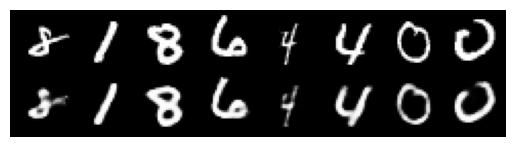

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.000795
Train Epoch: 8 [10000/60000 (17%)]	Loss: 0.000786
Train Epoch: 8 [20000/60000 (33%)]	Loss: 0.000770
Train Epoch: 8 [30000/60000 (50%)]	Loss: 0.000773
Train Epoch: 8 [40000/60000 (67%)]	Loss: 0.000772
Train Epoch: 8 [50000/60000 (83%)]	Loss: 0.000762
====> Epoch: 8 Average loss: 0.0008
Reconstructions: 


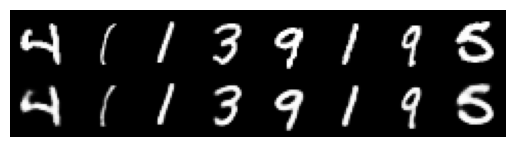

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.000756
Train Epoch: 9 [10000/60000 (17%)]	Loss: 0.000757
Train Epoch: 9 [20000/60000 (33%)]	Loss: 0.000734
Train Epoch: 9 [30000/60000 (50%)]	Loss: 0.000758
Train Epoch: 9 [40000/60000 (67%)]	Loss: 0.000759
Train Epoch: 9 [50000/60000 (83%)]	Loss: 0.000753
====> Epoch: 9 Average loss: 0.0008
Reconstructions: 


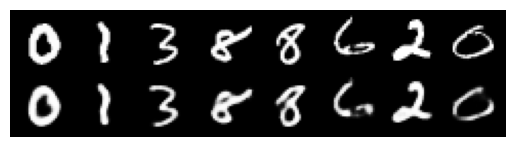

In [ ]:
# build model
train_BCE = np.zeros((num_epochs-1,3))
test_BCE = np.zeros((num_epochs-1,3))
tsne_result = np.zeros((10000,2,3))
labels = np.zeros((10000,3))
outputs = np.zeros((3,152,152,3))
c = 0
for hidden_dim in [32,128,512]:
  print('Hidden dim: ', hidden_dim)
  ae = Autoencoder(
    input_dim=input_dim,
    hidden_dim=hidden_dim,
    device=device
  )

  # put model on device
  if torch.cuda.is_available():
    ae.cuda()

  # device optimizer
  optimizer = optim.Adam(ae.parameters())

  # Define the loss function for a vanilla Autoencoder.
  #loss_fn = nn.MSELoss()
  loss_fn = nn.BCELoss(reduction='mean')

  # train
  for epoch in range(1, num_epochs):
    train_BCE[epoch-1,c] = train_single_epoch(
      model_cls="ae",
      model=ae,
      loss_fn=loss_fn,
      data_loader=train_loader,
      optimizer=optimizer,
      epoch=epoch
    )
    if epoch==9:
      test_BCE[epoch-1,c], outputs[:,:,:,c] = validate_single_epoch(model_cls="ae",
        model=ae,
        data_loader=test_loader,
        epoch=epoch)
    else:
      test_BCE[epoch-1,c], _ = validate_single_epoch(model_cls="ae",
        model=ae,
        data_loader=test_loader,
        epoch=epoch)
  
  embeddings, labels[:,c] = get_embeddings(model_cls="ae", model=ae, data_loader=test_loader)
  tsne = TSNE(n_components=2, random_state=42)  
  tsne_result[:,:,c] = tsne.fit_transform(embeddings)

  c += 1


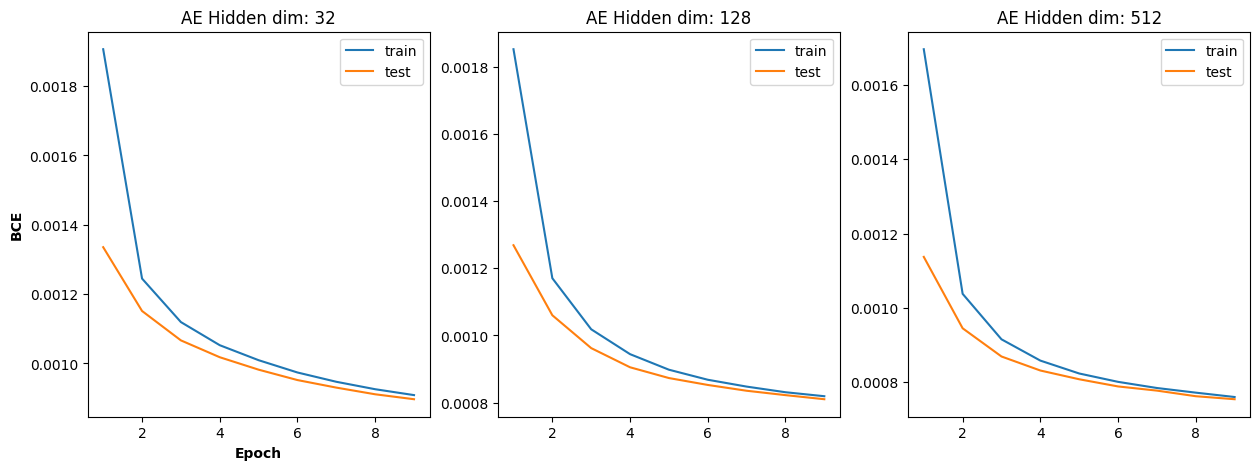

In [9]:
plt.figure(figsize=(15,5))
for k in range(3):
    
    plt.subplot(1,3,k+1)
    plt.plot(range(1,num_epochs),train_BCE[:,k],label='train')
    plt.plot(range(1,num_epochs),test_BCE[:,k],label='test')
    plt.legend()
    plt.title('AE Hidden dim: '+str([32,128,512][k]))
    if k==0:
        plt.ylabel('BCE',fontweight='bold')
        plt.xlabel('Epoch',fontweight='bold')


plt.show()

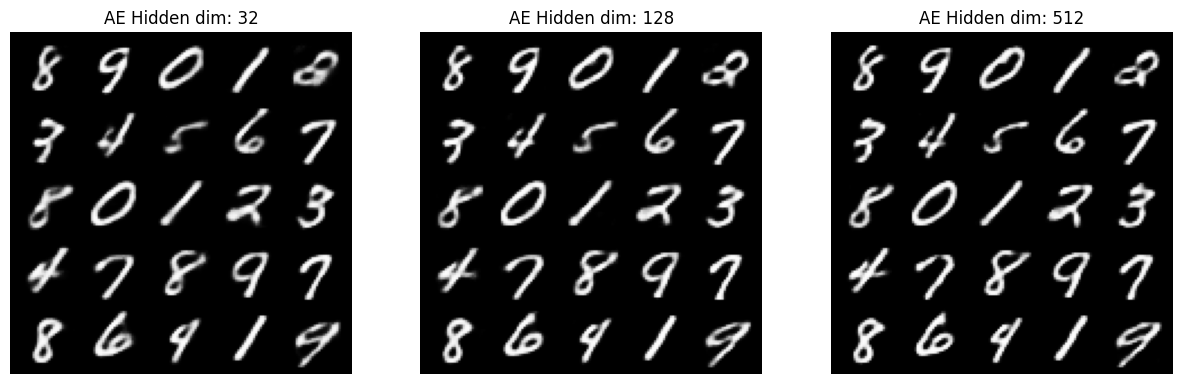

In [10]:
plt.figure(figsize=(15,5))
for k in range(3):
    plt.subplot(1,3,k+1)
    plt.imshow(outputs[:,:,:,k].transpose(1,2,0))
    plt.title('AE Hidden dim: '+str([32,128,512][k]))
    plt.axis('off')
plt.show()

/var/folders/b9/n530p3715jz14d00bjmthznh0000gn/T/ipykernel_39607/967375268.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(tsne_result[:, 0,k], tsne_result[:, 1,k], c=labels[:,k], cmap=plt.cm.get_cmap("jet", len(np.unique(labels))))


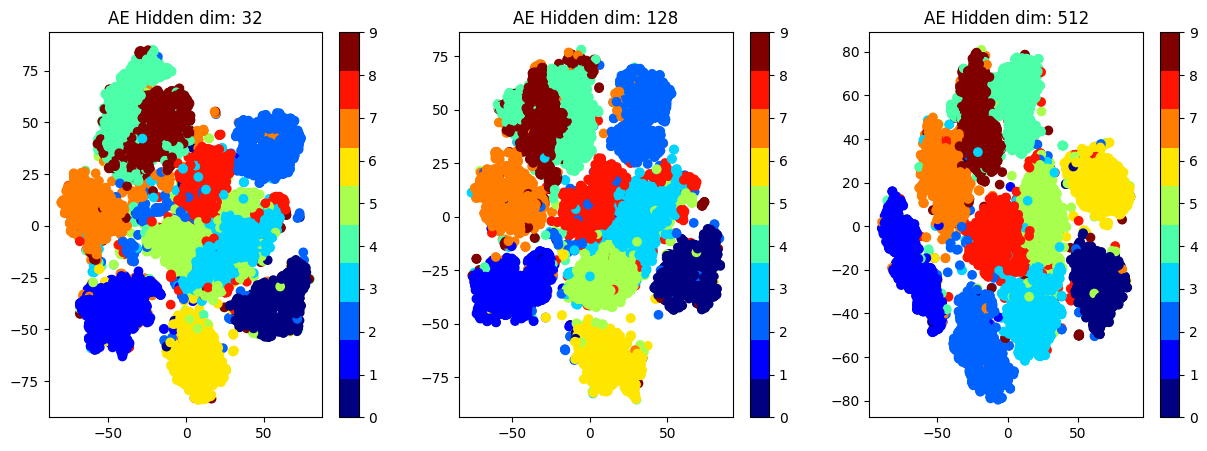

In [11]:
plt.figure(figsize=(15,5))
for k in range(3):
    plt.subplot(1,3,k+1)
    plt.scatter(tsne_result[:, 0,k], tsne_result[:, 1,k], c=labels[:,k], cmap=plt.cm.get_cmap("jet", len(np.unique(labels))))
    plt.colorbar()
    plt.title('AE Hidden dim: '+str([32,128,512][k]))
plt.show()

# Train Variational Autoencoder

In [ ]:
def vae_loss_fn(recon_batch, data, mu, log_var):
      
    BCE = F.binary_cross_entropy(recon_batch, data, reduction='sum')

    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
      
    KLD = -0.5 * torch.sum(1 + log_var - torch.pow(mu,2) - torch.exp(log_var))

    return BCE+KLD


Hidden dim:  32
Train Epoch: 1 [0/60000 (0%)]	Loss: 543.882148
Train Epoch: 1 [10000/60000 (17%)]	Loss: 194.569063
Train Epoch: 1 [20000/60000 (33%)]	Loss: 185.701113
Train Epoch: 1 [30000/60000 (50%)]	Loss: 175.208203
Train Epoch: 1 [40000/60000 (67%)]	Loss: 165.978223
Train Epoch: 1 [50000/60000 (83%)]	Loss: 173.842754
====> Epoch: 1 Average loss: 185.2979
Reconstructions: 


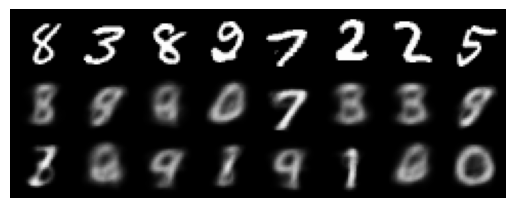

Train Epoch: 2 [0/60000 (0%)]	Loss: 167.893691
Train Epoch: 2 [10000/60000 (17%)]	Loss: 169.414668
Train Epoch: 2 [20000/60000 (33%)]	Loss: 155.690127
Train Epoch: 2 [30000/60000 (50%)]	Loss: 158.959004
Train Epoch: 2 [40000/60000 (67%)]	Loss: 163.666006
Train Epoch: 2 [50000/60000 (83%)]	Loss: 154.614248
====> Epoch: 2 Average loss: 161.8163
Reconstructions: 


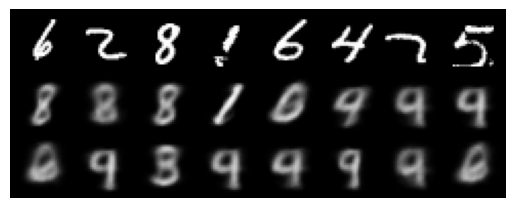

Train Epoch: 3 [0/60000 (0%)]	Loss: 158.537949
Train Epoch: 3 [10000/60000 (17%)]	Loss: 162.362168
Train Epoch: 3 [20000/60000 (33%)]	Loss: 158.323135
Train Epoch: 3 [30000/60000 (50%)]	Loss: 164.855273
Train Epoch: 3 [40000/60000 (67%)]	Loss: 155.690732
Train Epoch: 3 [50000/60000 (83%)]	Loss: 151.627930
====> Epoch: 3 Average loss: 157.5906
Reconstructions: 


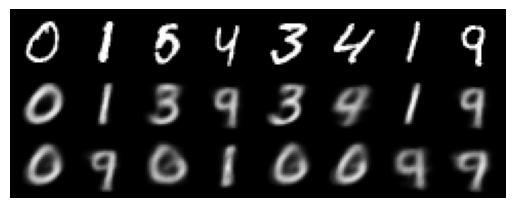

Train Epoch: 4 [0/60000 (0%)]	Loss: 159.455742
Train Epoch: 4 [10000/60000 (17%)]	Loss: 151.931582
Train Epoch: 4 [20000/60000 (33%)]	Loss: 156.607021
Train Epoch: 4 [30000/60000 (50%)]	Loss: 152.170156
Train Epoch: 4 [40000/60000 (67%)]	Loss: 152.602412
Train Epoch: 4 [50000/60000 (83%)]	Loss: 150.377676
====> Epoch: 4 Average loss: 154.5788
Reconstructions: 


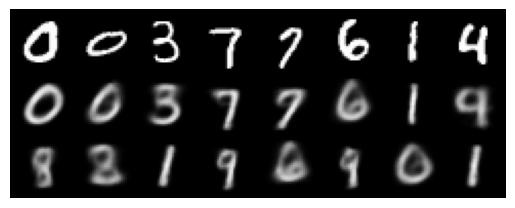

Train Epoch: 5 [0/60000 (0%)]	Loss: 149.579297
Train Epoch: 5 [10000/60000 (17%)]	Loss: 151.779863
Train Epoch: 5 [20000/60000 (33%)]	Loss: 160.811250
Train Epoch: 5 [30000/60000 (50%)]	Loss: 150.661855
Train Epoch: 5 [40000/60000 (67%)]	Loss: 150.169199
Train Epoch: 5 [50000/60000 (83%)]	Loss: 150.766650
====> Epoch: 5 Average loss: 152.2629
Reconstructions: 


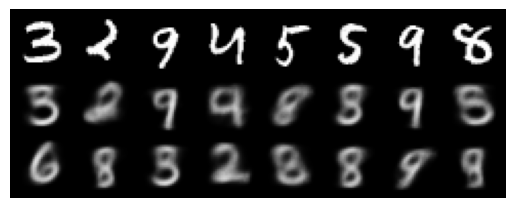

Train Epoch: 6 [0/60000 (0%)]	Loss: 155.320947
Train Epoch: 6 [10000/60000 (17%)]	Loss: 145.797080
Train Epoch: 6 [20000/60000 (33%)]	Loss: 150.696064
Train Epoch: 6 [30000/60000 (50%)]	Loss: 147.756084
Train Epoch: 6 [40000/60000 (67%)]	Loss: 156.682383
Train Epoch: 6 [50000/60000 (83%)]	Loss: 146.785830
====> Epoch: 6 Average loss: 150.6859
Reconstructions: 


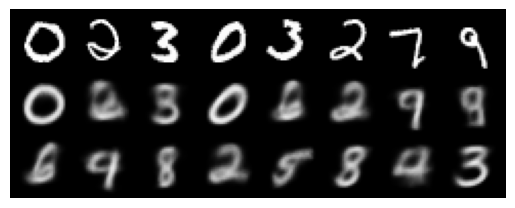

Train Epoch: 7 [0/60000 (0%)]	Loss: 146.106396
Train Epoch: 7 [10000/60000 (17%)]	Loss: 158.892598
Train Epoch: 7 [20000/60000 (33%)]	Loss: 145.894658
Train Epoch: 7 [30000/60000 (50%)]	Loss: 150.996992
Train Epoch: 7 [40000/60000 (67%)]	Loss: 142.835166
Train Epoch: 7 [50000/60000 (83%)]	Loss: 150.220391
====> Epoch: 7 Average loss: 149.4706
Reconstructions: 


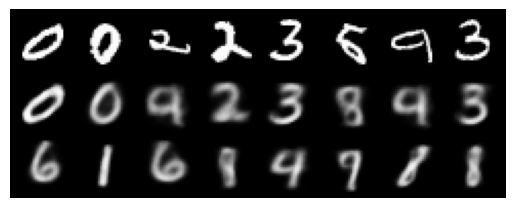

Train Epoch: 8 [0/60000 (0%)]	Loss: 150.551758
Train Epoch: 8 [10000/60000 (17%)]	Loss: 150.828516
Train Epoch: 8 [20000/60000 (33%)]	Loss: 148.065898
Train Epoch: 8 [30000/60000 (50%)]	Loss: 144.454863
Train Epoch: 8 [40000/60000 (67%)]	Loss: 150.172305
Train Epoch: 8 [50000/60000 (83%)]	Loss: 148.075420
====> Epoch: 8 Average loss: 148.4189
Reconstructions: 


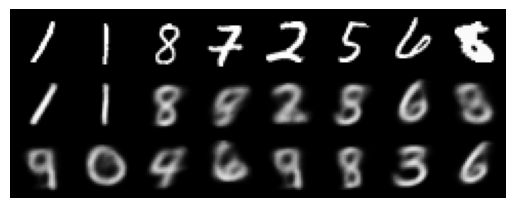

Train Epoch: 9 [0/60000 (0%)]	Loss: 145.600781
Train Epoch: 9 [10000/60000 (17%)]	Loss: 141.387109
Train Epoch: 9 [20000/60000 (33%)]	Loss: 142.752617
Train Epoch: 9 [30000/60000 (50%)]	Loss: 144.774463
Train Epoch: 9 [40000/60000 (67%)]	Loss: 148.809492
Train Epoch: 9 [50000/60000 (83%)]	Loss: 159.781563
====> Epoch: 9 Average loss: 147.5451
Reconstructions: 


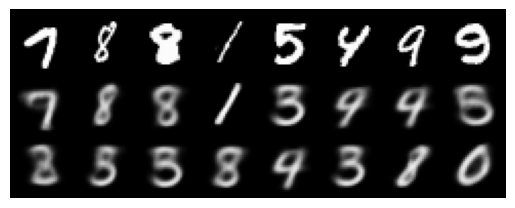

Hidden dim:  128
Train Epoch: 1 [0/60000 (0%)]	Loss: 544.860625
Train Epoch: 1 [10000/60000 (17%)]	Loss: 195.548242
Train Epoch: 1 [20000/60000 (33%)]	Loss: 176.053711
Train Epoch: 1 [30000/60000 (50%)]	Loss: 169.753047
Train Epoch: 1 [40000/60000 (67%)]	Loss: 172.039043
Train Epoch: 1 [50000/60000 (83%)]	Loss: 171.640547
====> Epoch: 1 Average loss: 181.6089
Reconstructions: 


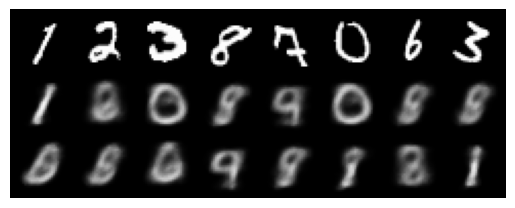

Train Epoch: 2 [0/60000 (0%)]	Loss: 158.553633
Train Epoch: 2 [10000/60000 (17%)]	Loss: 156.736680
Train Epoch: 2 [20000/60000 (33%)]	Loss: 159.263672
Train Epoch: 2 [30000/60000 (50%)]	Loss: 153.761875
Train Epoch: 2 [40000/60000 (67%)]	Loss: 160.292334
Train Epoch: 2 [50000/60000 (83%)]	Loss: 165.325586
====> Epoch: 2 Average loss: 159.4480
Reconstructions: 


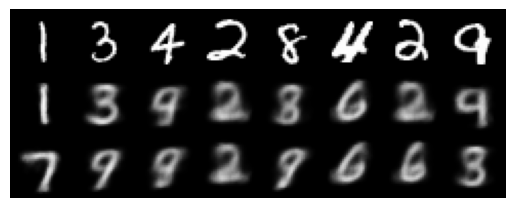

Train Epoch: 3 [0/60000 (0%)]	Loss: 151.888027
Train Epoch: 3 [10000/60000 (17%)]	Loss: 154.316494
Train Epoch: 3 [20000/60000 (33%)]	Loss: 150.929082
Train Epoch: 3 [30000/60000 (50%)]	Loss: 151.806924
Train Epoch: 3 [40000/60000 (67%)]	Loss: 153.569141
Train Epoch: 3 [50000/60000 (83%)]	Loss: 147.174219
====> Epoch: 3 Average loss: 154.5538
Reconstructions: 


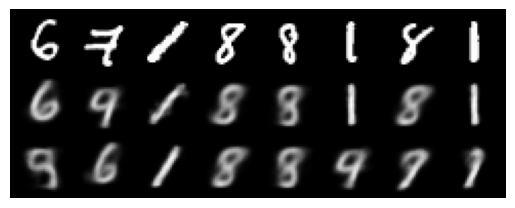

Train Epoch: 4 [0/60000 (0%)]	Loss: 150.431025
Train Epoch: 4 [10000/60000 (17%)]	Loss: 151.905937
Train Epoch: 4 [20000/60000 (33%)]	Loss: 152.870273
Train Epoch: 4 [30000/60000 (50%)]	Loss: 154.361143
Train Epoch: 4 [40000/60000 (67%)]	Loss: 161.849053
Train Epoch: 4 [50000/60000 (83%)]	Loss: 151.030557
====> Epoch: 4 Average loss: 151.4317
Reconstructions: 


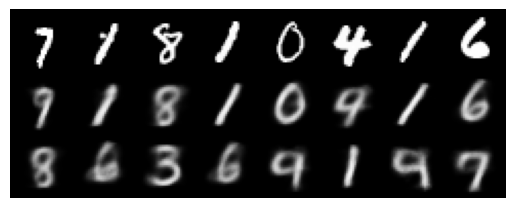

Train Epoch: 5 [0/60000 (0%)]	Loss: 143.094277
Train Epoch: 5 [10000/60000 (17%)]	Loss: 154.342910
Train Epoch: 5 [20000/60000 (33%)]	Loss: 150.928096
Train Epoch: 5 [30000/60000 (50%)]	Loss: 145.879570
Train Epoch: 5 [40000/60000 (67%)]	Loss: 144.906523
Train Epoch: 5 [50000/60000 (83%)]	Loss: 145.728467
====> Epoch: 5 Average loss: 149.1527
Reconstructions: 


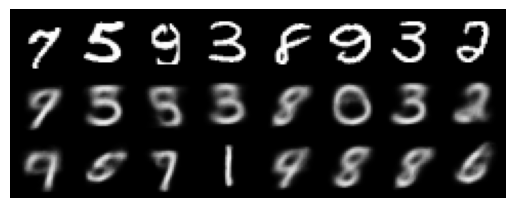

Train Epoch: 6 [0/60000 (0%)]	Loss: 146.397402
Train Epoch: 6 [10000/60000 (17%)]	Loss: 144.747197
Train Epoch: 6 [20000/60000 (33%)]	Loss: 146.406416
Train Epoch: 6 [30000/60000 (50%)]	Loss: 148.114023
Train Epoch: 6 [40000/60000 (67%)]	Loss: 144.134521
Train Epoch: 6 [50000/60000 (83%)]	Loss: 142.888887
====> Epoch: 6 Average loss: 147.3870
Reconstructions: 


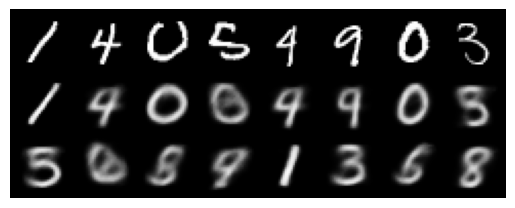

Train Epoch: 7 [0/60000 (0%)]	Loss: 146.238223
Train Epoch: 7 [10000/60000 (17%)]	Loss: 150.284883
Train Epoch: 7 [20000/60000 (33%)]	Loss: 144.530371
Train Epoch: 7 [30000/60000 (50%)]	Loss: 149.774951
Train Epoch: 7 [40000/60000 (67%)]	Loss: 141.957178
Train Epoch: 7 [50000/60000 (83%)]	Loss: 144.760674
====> Epoch: 7 Average loss: 146.1004
Reconstructions: 


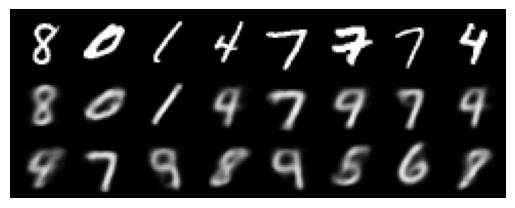

Train Epoch: 8 [0/60000 (0%)]	Loss: 149.348350
Train Epoch: 8 [10000/60000 (17%)]	Loss: 148.122441
Train Epoch: 8 [20000/60000 (33%)]	Loss: 145.435762
Train Epoch: 8 [30000/60000 (50%)]	Loss: 140.155986
Train Epoch: 8 [40000/60000 (67%)]	Loss: 152.005859
Train Epoch: 8 [50000/60000 (83%)]	Loss: 140.899102
====> Epoch: 8 Average loss: 145.1364
Reconstructions: 


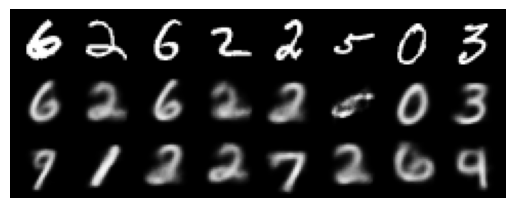

Train Epoch: 9 [0/60000 (0%)]	Loss: 146.691074
Train Epoch: 9 [10000/60000 (17%)]	Loss: 149.916338
Train Epoch: 9 [20000/60000 (33%)]	Loss: 143.319990
Train Epoch: 9 [30000/60000 (50%)]	Loss: 150.597725
Train Epoch: 9 [40000/60000 (67%)]	Loss: 137.926514
Train Epoch: 9 [50000/60000 (83%)]	Loss: 147.634414
====> Epoch: 9 Average loss: 144.2270
Reconstructions: 


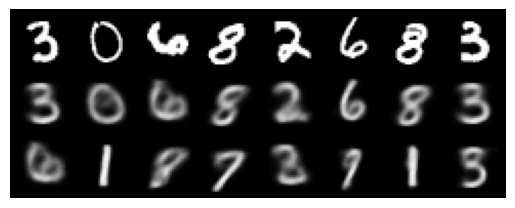

Hidden dim:  512
Train Epoch: 1 [0/60000 (0%)]	Loss: 545.653477
Train Epoch: 1 [10000/60000 (17%)]	Loss: 184.817129
Train Epoch: 1 [20000/60000 (33%)]	Loss: 175.406895
Train Epoch: 1 [30000/60000 (50%)]	Loss: 168.974805
Train Epoch: 1 [40000/60000 (67%)]	Loss: 169.033086
Train Epoch: 1 [50000/60000 (83%)]	Loss: 167.730469
====> Epoch: 1 Average loss: 178.2436
Reconstructions: 


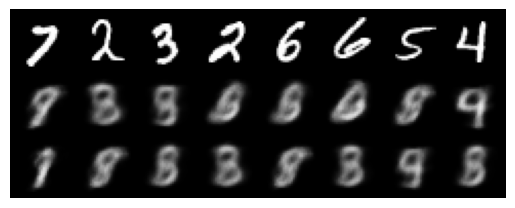

Train Epoch: 2 [0/60000 (0%)]	Loss: 155.527529
Train Epoch: 2 [10000/60000 (17%)]	Loss: 163.770850
Train Epoch: 2 [20000/60000 (33%)]	Loss: 159.579170
Train Epoch: 2 [30000/60000 (50%)]	Loss: 145.750254
Train Epoch: 2 [40000/60000 (67%)]	Loss: 167.399609
Train Epoch: 2 [50000/60000 (83%)]	Loss: 153.637832
====> Epoch: 2 Average loss: 157.1008
Reconstructions: 


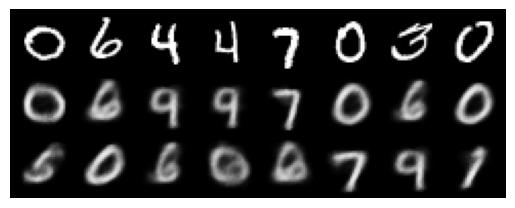

Train Epoch: 3 [0/60000 (0%)]	Loss: 165.060840
Train Epoch: 3 [10000/60000 (17%)]	Loss: 155.016885
Train Epoch: 3 [20000/60000 (33%)]	Loss: 150.257129
Train Epoch: 3 [30000/60000 (50%)]	Loss: 164.104492
Train Epoch: 3 [40000/60000 (67%)]	Loss: 148.852812
Train Epoch: 3 [50000/60000 (83%)]	Loss: 145.576455
====> Epoch: 3 Average loss: 152.0674
Reconstructions: 


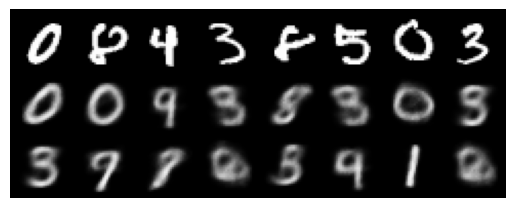

Train Epoch: 4 [0/60000 (0%)]	Loss: 156.473633
Train Epoch: 4 [10000/60000 (17%)]	Loss: 146.900117
Train Epoch: 4 [20000/60000 (33%)]	Loss: 151.218828
Train Epoch: 4 [30000/60000 (50%)]	Loss: 144.546406
Train Epoch: 4 [40000/60000 (67%)]	Loss: 140.718740
Train Epoch: 4 [50000/60000 (83%)]	Loss: 146.306992
====> Epoch: 4 Average loss: 149.0710
Reconstructions: 


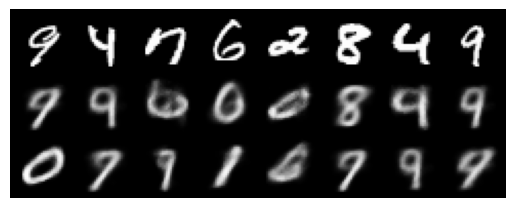

Train Epoch: 5 [0/60000 (0%)]	Loss: 146.469307
Train Epoch: 5 [10000/60000 (17%)]	Loss: 147.903125
Train Epoch: 5 [20000/60000 (33%)]	Loss: 147.779834
Train Epoch: 5 [30000/60000 (50%)]	Loss: 139.696543
Train Epoch: 5 [40000/60000 (67%)]	Loss: 145.391885
Train Epoch: 5 [50000/60000 (83%)]	Loss: 147.614199
====> Epoch: 5 Average loss: 146.9617
Reconstructions: 


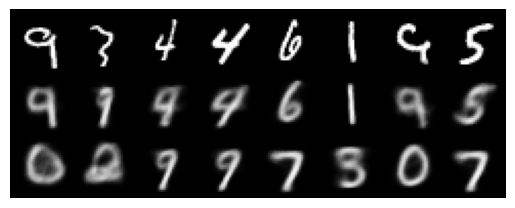

Train Epoch: 6 [0/60000 (0%)]	Loss: 140.147227
Train Epoch: 6 [10000/60000 (17%)]	Loss: 145.620039
Train Epoch: 6 [20000/60000 (33%)]	Loss: 144.086182
Train Epoch: 6 [30000/60000 (50%)]	Loss: 148.242207
Train Epoch: 6 [40000/60000 (67%)]	Loss: 133.687764
Train Epoch: 6 [50000/60000 (83%)]	Loss: 141.863477
====> Epoch: 6 Average loss: 145.5696
Reconstructions: 


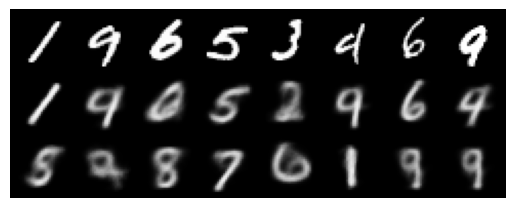

Train Epoch: 7 [0/60000 (0%)]	Loss: 147.859219
Train Epoch: 7 [10000/60000 (17%)]	Loss: 146.793457
Train Epoch: 7 [20000/60000 (33%)]	Loss: 145.354961
Train Epoch: 7 [30000/60000 (50%)]	Loss: 146.117451
Train Epoch: 7 [40000/60000 (67%)]	Loss: 140.570869
Train Epoch: 7 [50000/60000 (83%)]	Loss: 142.411758
====> Epoch: 7 Average loss: 144.5423
Reconstructions: 


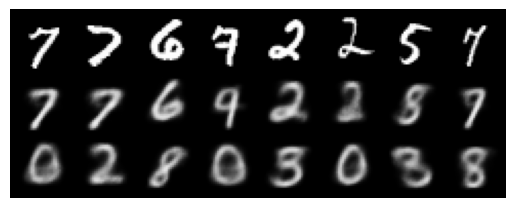

Train Epoch: 8 [0/60000 (0%)]	Loss: 147.134053
Train Epoch: 8 [10000/60000 (17%)]	Loss: 147.337900
Train Epoch: 8 [20000/60000 (33%)]	Loss: 140.478193
Train Epoch: 8 [30000/60000 (50%)]	Loss: 145.934756
Train Epoch: 8 [40000/60000 (67%)]	Loss: 143.339687
Train Epoch: 8 [50000/60000 (83%)]	Loss: 148.668613
====> Epoch: 8 Average loss: 143.6470
Reconstructions: 


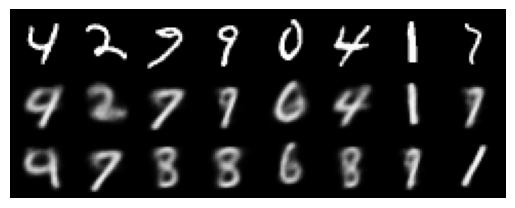

Train Epoch: 9 [0/60000 (0%)]	Loss: 141.663613
Train Epoch: 9 [10000/60000 (17%)]	Loss: 146.134287
Train Epoch: 9 [20000/60000 (33%)]	Loss: 144.861006
Train Epoch: 9 [30000/60000 (50%)]	Loss: 143.355732
Train Epoch: 9 [40000/60000 (67%)]	Loss: 132.801172
Train Epoch: 9 [50000/60000 (83%)]	Loss: 135.639893
====> Epoch: 9 Average loss: 142.9330
Reconstructions: 


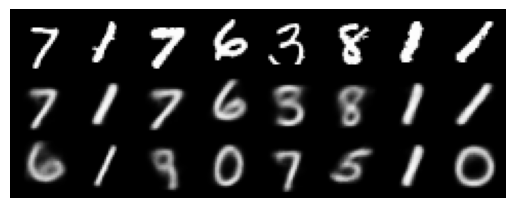

In [13]:
train_BCE = np.zeros((num_epochs-1,3))
test_BCE = np.zeros((num_epochs-1,3))
outputs = np.zeros((3,152,152,3))
labels = np.zeros((10000,3))
c = 0
tsne_result = np.zeros((10000,2,3))
for hidden_dim in [32, 128, 512]:
  print('Hidden dim: ', hidden_dim)
  # build model
  vae = VAE(
    input_dim=input_dim,
    hidden_dim=hidden_dim,
    latent_dim=latent_dim,
    device=device
  )

  # put model on device
  if torch.cuda.is_available():
    vae.cuda()

  # device optimizer
  vae_optimizer = optim.Adam(vae.parameters())


  for epoch in range(1, num_epochs):
    train_BCE[epoch-1,c] = train_single_epoch(
      model_cls="vae",
      model=vae,
      loss_fn=vae_loss_fn,
      data_loader=train_loader,
      optimizer=vae_optimizer,
      epoch=epoch
    )
    if epoch == 9:
        test_BCE[epoch-1,c], outputs[:,:,:,c] = validate_single_epoch(model_cls="vae",
        model=vae,
        data_loader=test_loader,
        epoch=epoch)
    else:
        test_BCE[epoch-1,c], _ = validate_single_epoch(model_cls="vae",
        model=vae,
        data_loader=test_loader,
        epoch=epoch)
    
  embeddings, labels[:,c] = get_embeddings(model_cls="vae", model=vae, data_loader=test_loader)
  tsne = TSNE(n_components=2, random_state=42)  
  tsne_result[:,:,c] = tsne.fit_transform(embeddings)

  
  c += 1


  

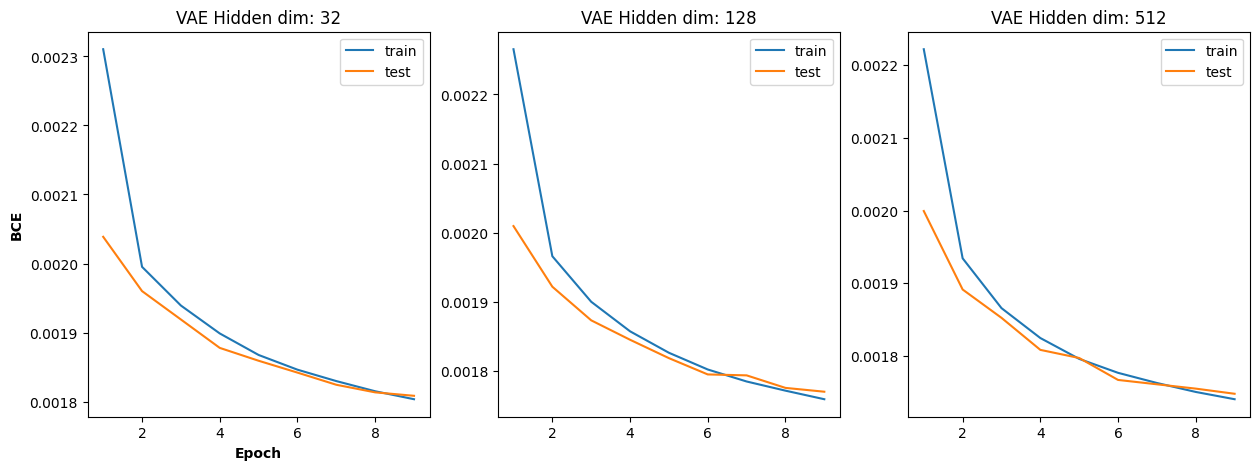

In [14]:
plt.figure(figsize=(15,5))
for k in range(3):
    plt.subplot(1,3,k+1)
    plt.plot(range(1,num_epochs),train_BCE[:,k],label='train')
    plt.plot(range(1,num_epochs),test_BCE[:,k],label='test')
    plt.legend()
    plt.title('VAE Hidden dim: '+str([32,128,512][k]))
    if k==0:
        plt.ylabel('BCE',fontweight='bold')
        plt.xlabel('Epoch',fontweight='bold')



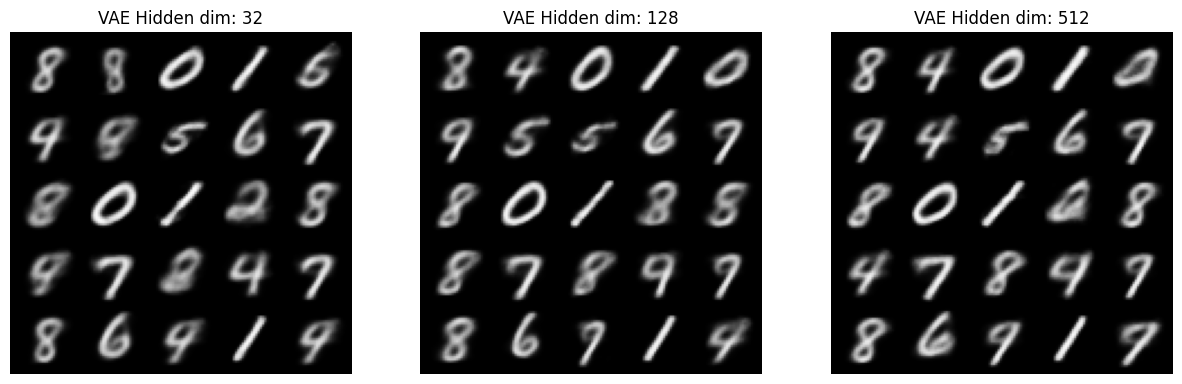

In [15]:
plt.figure(figsize=(15,5))
for k in range(3):
    plt.subplot(1,3,k+1)
    plt.imshow(outputs[:,:,:,k].transpose(1,2,0))
    plt.title('VAE Hidden dim: '+str([32,128,512][k]))
    plt.axis('off')
plt.show()

/var/folders/b9/n530p3715jz14d00bjmthznh0000gn/T/ipykernel_39607/625431773.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(tsne_result[:, 0,k], tsne_result[:, 1,k], c=labels[:,k], cmap=plt.cm.get_cmap("jet", len(np.unique(labels))))


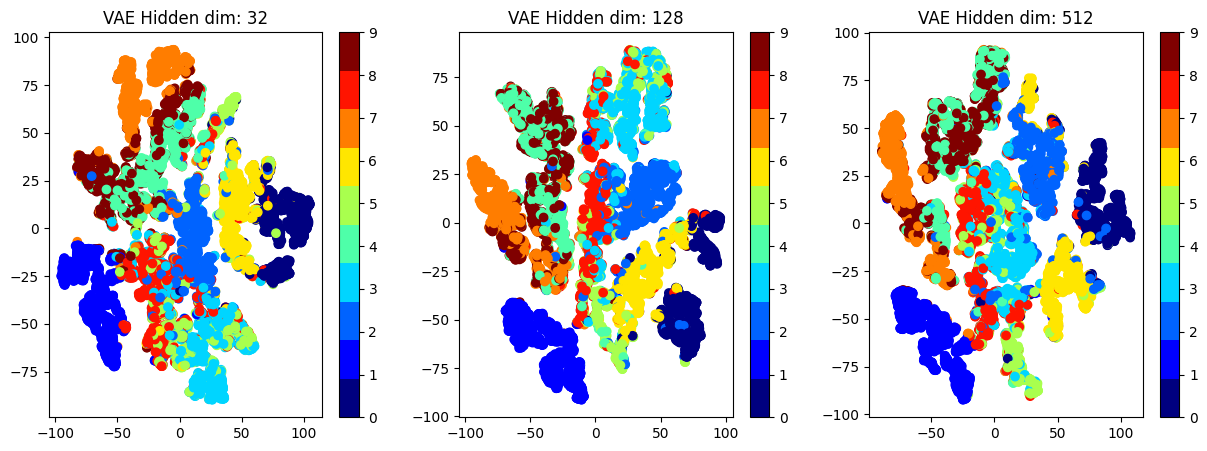

In [16]:
plt.figure(figsize=(15,5))
for k in range(3):
    plt.subplot(1,3,k+1)
    plt.scatter(tsne_result[:, 0,k], tsne_result[:, 1,k], c=labels[:,k], cmap=plt.cm.get_cmap("jet", len(np.unique(labels))))
    plt.colorbar()
    plt.title('VAE Hidden dim: '+str([32,128,512][k]))
plt.show()

# Bonus task: Conditional VAE

In [ ]:
class ConditionalVAE(nn.Module):

  def __init__(
      self,
      input_dim: int = 784,
      hidden_dim: int = 256,
      latent_dim: int= 2,
      embedding_dim: int = 64,
      num_classes: int = 10,
      device: str = "cuda"
  ):
    super(ConditionalVAE, self).__init__()

    self.latent_dim = latent_dim
    self.device = device

    # Encoder architecture:
    # 2 fully connected layers with ReLU activations

    # Decoder architecture:
    # 3 fully connected layers with ReLU activations

    # Separate linear layers to predict the latent mean and logvar

    # Use an embedding layer to encode the class label.
    # See https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html.

  

    self.label_embed = nn.Embedding(num_classes, embedding_dim)

    self.encoder = nn.Sequential(
        nn.Linear(input_dim + embedding_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, hidden_dim),
        nn.ReLU(),
    )

    self.decoder =  nn.Sequential(      
        nn.Linear(latent_dim+embedding_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, input_dim),
        nn.Sigmoid(),
    )

    self.mean = nn.Linear(hidden_dim, latent_dim)

    self.log_var = nn.Linear(hidden_dim, latent_dim)


  def reparameterize(self, mu, log_var):
    std = torch.exp(0.5 * log_var)
    eps = torch.randn_like(std)
    return eps.mul(std).add_(mu)  # return z sample

  def sample(self, n, class_label=0):
    sample = torch.randn(n, self.latent_dim).to(self.device)
    class_label = torch.tensor(class_label).repeat(n).to(self.device)
    return self.decode(sample, class_label)

  def decode(self, x, class_label):
    # embed the class label
    label_embed = self.label_embed(class_label)
    decoder_input = torch.cat([x, label_embed], dim=-1)
    z = self.decoder(decoder_input)
    return z

  def encode(self, x, class_label):
    # embed the class label
    label_embed = self.label_embed(class_label)

    encoder_input = torch.cat([x.view(x.shape[0], -1), label_embed], dim=-1)
    encode_output = self.encoder(encoder_input)

    mu = self.mean(encode_output)
    log_var = self.log_var(encode_output)
    return mu, log_var

  def forward(self, x, class_label):
    mu, log_var = self.encode(x, class_label)
    z = self.reparameterize(mu, log_var)
    return self.decode(z, class_label), mu, log_var

# Bonus task: Train CVAE

Hidden dim:  512
Train Epoch: 1 [0/60000 (0%)]	Loss: 547.087227
Train Epoch: 1 [10000/60000 (17%)]	Loss: 173.825605
Train Epoch: 1 [20000/60000 (33%)]	Loss: 169.220000
Train Epoch: 1 [30000/60000 (50%)]	Loss: 146.158984
Train Epoch: 1 [40000/60000 (67%)]	Loss: 146.071025
Train Epoch: 1 [50000/60000 (83%)]	Loss: 140.163252
====> Epoch: 1 Average loss: 159.4432
Reconstructions: 


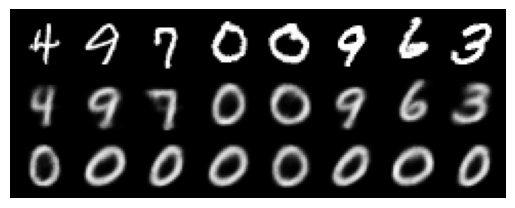

Train Epoch: 2 [0/60000 (0%)]	Loss: 145.387354
Train Epoch: 2 [10000/60000 (17%)]	Loss: 138.984844
Train Epoch: 2 [20000/60000 (33%)]	Loss: 134.239160
Train Epoch: 2 [30000/60000 (50%)]	Loss: 137.404336
Train Epoch: 2 [40000/60000 (67%)]	Loss: 136.473594
Train Epoch: 2 [50000/60000 (83%)]	Loss: 132.146113
====> Epoch: 2 Average loss: 137.2605
Reconstructions: 


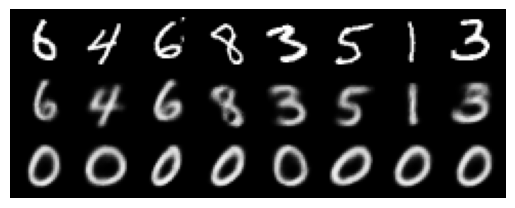

Train Epoch: 3 [0/60000 (0%)]	Loss: 134.549424
Train Epoch: 3 [10000/60000 (17%)]	Loss: 131.461445
Train Epoch: 3 [20000/60000 (33%)]	Loss: 131.600225
Train Epoch: 3 [30000/60000 (50%)]	Loss: 131.508984
Train Epoch: 3 [40000/60000 (67%)]	Loss: 129.372490
Train Epoch: 3 [50000/60000 (83%)]	Loss: 137.518857
====> Epoch: 3 Average loss: 134.3445
Reconstructions: 


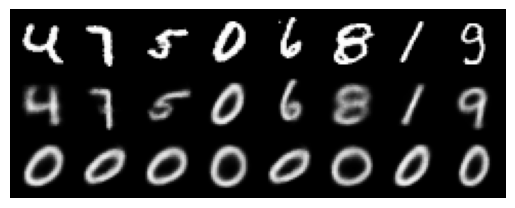

Train Epoch: 4 [0/60000 (0%)]	Loss: 134.577236
Train Epoch: 4 [10000/60000 (17%)]	Loss: 133.774482
Train Epoch: 4 [20000/60000 (33%)]	Loss: 124.174082
Train Epoch: 4 [30000/60000 (50%)]	Loss: 138.482617
Train Epoch: 4 [40000/60000 (67%)]	Loss: 125.832480
Train Epoch: 4 [50000/60000 (83%)]	Loss: 133.053232
====> Epoch: 4 Average loss: 132.9695
Reconstructions: 


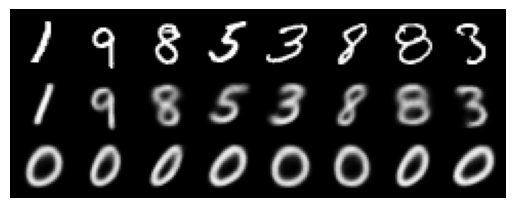

Train Epoch: 5 [0/60000 (0%)]	Loss: 134.321006
Train Epoch: 5 [10000/60000 (17%)]	Loss: 136.025068
Train Epoch: 5 [20000/60000 (33%)]	Loss: 133.440049
Train Epoch: 5 [30000/60000 (50%)]	Loss: 135.551104
Train Epoch: 5 [40000/60000 (67%)]	Loss: 128.071914
Train Epoch: 5 [50000/60000 (83%)]	Loss: 129.032998
====> Epoch: 5 Average loss: 132.0806
Reconstructions: 


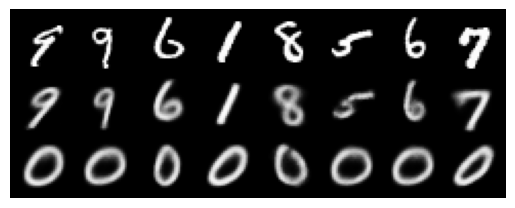

Train Epoch: 6 [0/60000 (0%)]	Loss: 137.595996
Train Epoch: 6 [10000/60000 (17%)]	Loss: 135.253516
Train Epoch: 6 [20000/60000 (33%)]	Loss: 129.227051
Train Epoch: 6 [30000/60000 (50%)]	Loss: 134.014600
Train Epoch: 6 [40000/60000 (67%)]	Loss: 126.878916
Train Epoch: 6 [50000/60000 (83%)]	Loss: 131.458398
====> Epoch: 6 Average loss: 131.4703
Reconstructions: 


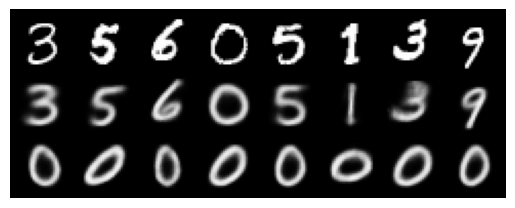

Train Epoch: 7 [0/60000 (0%)]	Loss: 125.251084
Train Epoch: 7 [10000/60000 (17%)]	Loss: 131.961719
Train Epoch: 7 [20000/60000 (33%)]	Loss: 138.169326
Train Epoch: 7 [30000/60000 (50%)]	Loss: 138.743848
Train Epoch: 7 [40000/60000 (67%)]	Loss: 123.025977
Train Epoch: 7 [50000/60000 (83%)]	Loss: 131.574229
====> Epoch: 7 Average loss: 130.9487
Reconstructions: 


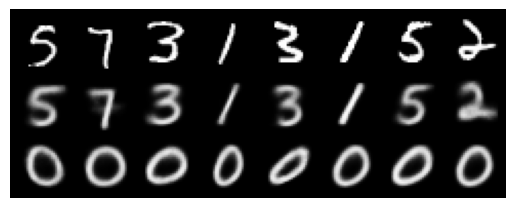

Train Epoch: 8 [0/60000 (0%)]	Loss: 132.172197
Train Epoch: 8 [10000/60000 (17%)]	Loss: 122.053945
Train Epoch: 8 [20000/60000 (33%)]	Loss: 127.550938
Train Epoch: 8 [30000/60000 (50%)]	Loss: 130.091436
Train Epoch: 8 [40000/60000 (67%)]	Loss: 128.490938
Train Epoch: 8 [50000/60000 (83%)]	Loss: 132.877422
====> Epoch: 8 Average loss: 130.5634
Reconstructions: 


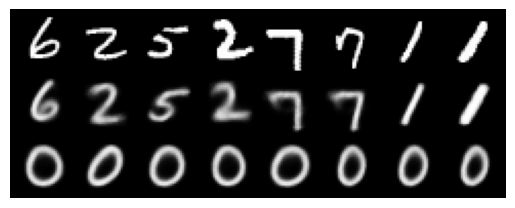

Train Epoch: 9 [0/60000 (0%)]	Loss: 125.030107
Train Epoch: 9 [10000/60000 (17%)]	Loss: 135.885879
Train Epoch: 9 [20000/60000 (33%)]	Loss: 128.507832
Train Epoch: 9 [30000/60000 (50%)]	Loss: 134.688340
Train Epoch: 9 [40000/60000 (67%)]	Loss: 132.196250
Train Epoch: 9 [50000/60000 (83%)]	Loss: 134.515654
====> Epoch: 9 Average loss: 130.1767
Reconstructions: 


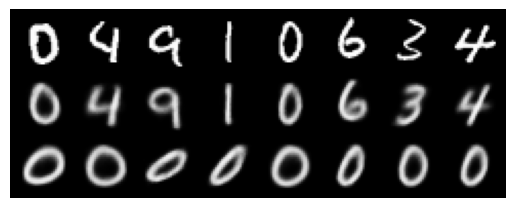

In [23]:
# build model
num_epochs = 10
train_BCE = np.zeros(num_epochs-1)
test_BCE = np.zeros(num_epochs-1)

for hidden_dim in [512]:
  print('Hidden dim: ', hidden_dim)
  cvae = ConditionalVAE(
    input_dim=input_dim,
    hidden_dim=hidden_dim,
    latent_dim=latent_dim,
    num_classes=10,
    device=device
  )

  # put model on device
  if torch.cuda.is_available():
    cvae.cuda()

  # device optimizer
  cvae_optimizer = optim.Adam(cvae.parameters())

  for epoch in range(1, num_epochs):
    train_BCE[epoch-1] = train_single_epoch(
      model_cls="cvae",
      model=cvae,
      loss_fn=vae_loss_fn,
      data_loader=train_loader,
      optimizer=cvae_optimizer,
      epoch=epoch
    )
    if epoch == 9:
        test_BCE[epoch-1], outputs = validate_single_epoch(model_cls="cvae",
        model=cvae,
        data_loader=test_loader,
        epoch=epoch)
    else:
        test_BCE[epoch-1], _ = validate_single_epoch(model_cls="cvae",
        model=cvae,
        data_loader=test_loader,
        epoch=epoch)
      
  embeddings, labels = get_embeddings(model_cls="cvae", model=cvae, data_loader=test_loader)
  tsne = TSNE(n_components=2, random_state=42)  
  tsne_result = tsne.fit_transform(embeddings)

    


Text(0.5, 0, 'Epoch')

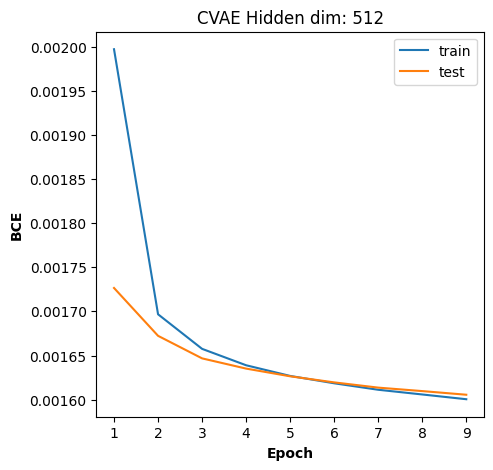

In [24]:
plt.figure(figsize=(5,5))
plt.plot(range(1,num_epochs),train_BCE,label='train')
plt.plot(range(1,num_epochs),test_BCE,label='test')
plt.legend()
plt.title('CVAE Hidden dim: '+str(512))
plt.ylabel('BCE',fontweight='bold')
plt.xlabel('Epoch',fontweight='bold')



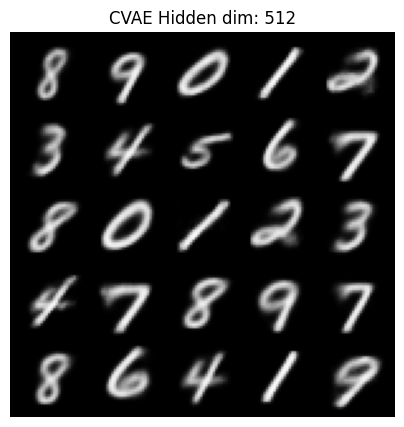

In [25]:
plt.figure(figsize=(5,5))
plt.imshow(outputs.transpose(1,2,0))
plt.title('CVAE Hidden dim: '+str([32,128,512][2]))
plt.axis('off')
plt.show()

/var/folders/b9/n530p3715jz14d00bjmthznh0000gn/T/ipykernel_39607/3368638082.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=labels, cmap=plt.cm.get_cmap("jet", len(np.unique(labels))))


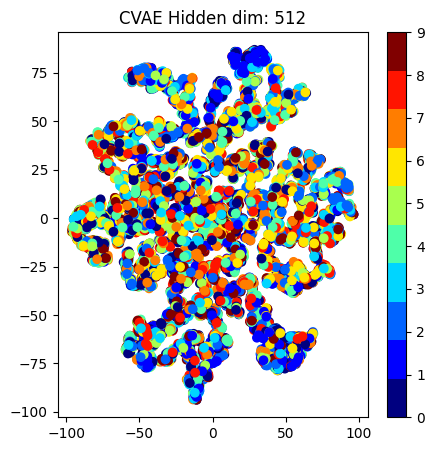

In [26]:
plt.figure(figsize=(5,5))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=labels, cmap=plt.cm.get_cmap("jet", len(np.unique(labels))))
plt.colorbar()
plt.title('CVAE Hidden dim: '+str([32,128,512][2]))
plt.show()

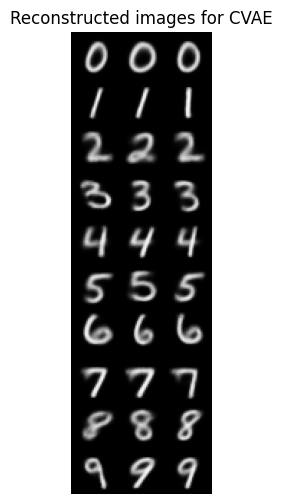

In [27]:
plt.figure(figsize=(2,6))
reconstructed_images = []

data_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

for target_class in range(10):
    images_collected = 0
    
    for data, class_label in data_loader:
        if images_collected >= 3:
            break
        
        if class_label[0] == target_class:
            data = data.to(device)
            with torch.no_grad():
                recon_batch, mu, log_var = cvae(data, class_label)
            
            reconstructed_images.append(recon_batch.view(1, 1, 28, 28).cpu())

            images_collected += 1

reconstructed_images = torch.cat(reconstructed_images, dim=0)

grid = torchvision.utils.make_grid(reconstructed_images, nrow=3)
plt.imshow(grid.permute(1, 2, 0))
plt.title('Reconstructed images for CVAE')
plt.axis('off')
plt.show()
